[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=lab/tree/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install git+https://github.com/atmos-cloud-sim-uj/PySDM-examples.git
    !ldconfig

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

from PySDM.backends.numba.test_helpers.bdf import patch_core
from PySDM.physics import formulae as phys
import PySDM.physics.constants as const

from PySDM_examples.utils.show_plot import show_plot
from PySDM_examples.SURF_activation.example import Simulation
from PySDM_examples.SURF_activation.settings import Settings

In [22]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [23]:
def runner():
    settings = Settings(n_sd = 10000)

    settings.rtol_x = 1e-3

    simulation = Simulation(settings)
    
    output = simulation.run()
    result = {}
    
    # TODO the settings.dt_output gets seakily overwritten later in this way
    result['dt_output'] = settings.total_time/settings.n_steps
    
    result['r_bins_values'] = np.array(output['r_bins_values']).T / (settings.mass_of_dry_air)
    result['r_bins_edges'] = settings.r_bins_edges
    result['r'] = np.array(output['r']).T * si.metres
    
    result['t'] = output["t"] * si.seconds
    result['z'] = output["z"] * si.metres
    result['S'] = np.array(output["S"]) * si.dimensionless
    result['q'] = (settings.q0 - np.array(output["qv"])) * si.kilogram / si.kilogram
    result['T'] = np.array(output["T"])
    result['n'] = settings.n / (settings.mass_of_dry_air * si.kilogram)
    
    result['dt_max'] = settings.dt_max
    result['dt_cond_max'] = output['dt_cond_max']
    result['dt_cond_min'] = output['dt_cond_min']
    
    result['activating_rate'] = output["activating_rate"]
    #result['peak_supersaturation'] = output["peak_supersaturation"] TODO
 
    result['r_dry'] = settings.r_dry
    result['kappa'] = settings.kappa
    
    arg_T = result['T'].reshape(-1,1).repeat(len(result['n']), axis = 1)
    sgm = const.sgm  # note: ignoring sigma dependence on T, rd, rw
    result['r_cr'] = simulation.formulae.hygroscopicity.r_cr(settings.kappa, settings.r_dry, arg_T, sgm).transpose()
    
    return  result

outputs = []
outputs.append(runner())

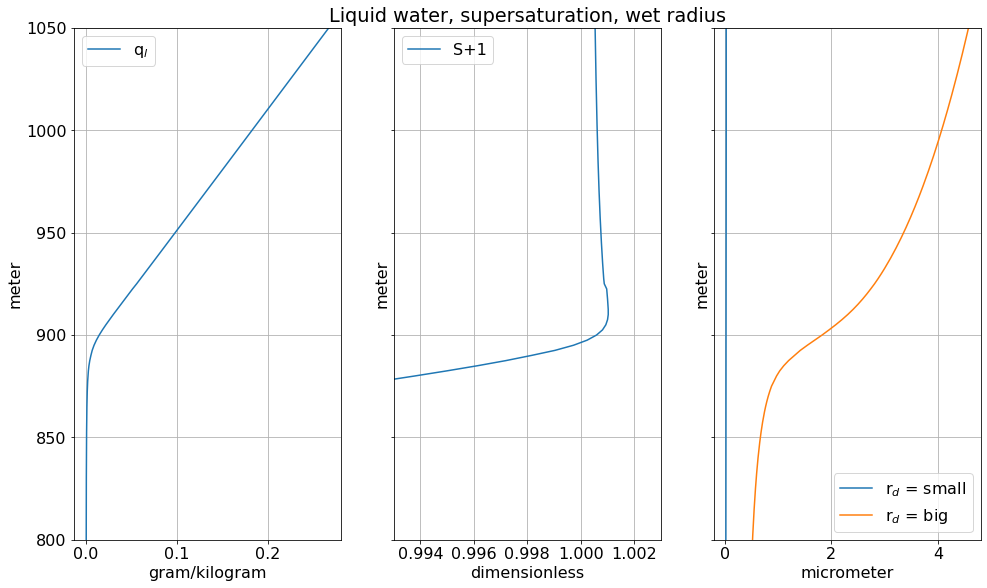

HTML(value="<a href='./q_S_rd.pdf' target='_blank'>./q_S_rd.pdf</a><br>")

In [24]:
figsize = (14,9)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=figsize)
ax = np.array(ax).reshape(1, 3)

for i, output in enumerate(outputs):
        
    ax[i,1].set_title('Liquid water, supersaturation, wet radius')
    
    ax[i,0].set_ylim([800, 1050])
    ax[i,0].plot(output['q'], output['z'], label="q$_l$")
    ax[i,0].xaxis.set_units(si.gram / si.kilogram)
    ax[i,0].grid()
    ax[i,0].legend(loc='best')

    ax[i,1].plot(output['S']+1, output['z'], label="S+1")
    ax[i,1].grid()
    ax[i,1].legend(loc='best')
    ax[i,1].set_xlim([0.993, 1.003])

    ax[i,2].plot(output['r'][40], output['z'], label="r$_d$ = small")
    ax[i,2].plot(output['r'][8000], output['z'], label="r$_d$ = big")
    ax[i,2].grid()
    ax[i,2].xaxis.set_units(si.micrometre)
    ax[i,2].legend(loc='best')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

show_plot(filename='q_S_rd.pdf')

In [25]:
def rmean(r, n, mask): # TODO #412: move to products
    """Compute mean radii among those radii that are greater than mask value"""
    nt = r.shape[1]
    n_dot_r = n.magnitude.dot(np.where(mask, r.magnitude, 0))
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(nt, axis=1), 0), axis=0)
    rmean = np.full(nt, np.nan)
    nmask = n_tot > 0
    rmean[nmask] = n_dot_r[nmask] / n_tot[nmask]
    return rmean * r.units

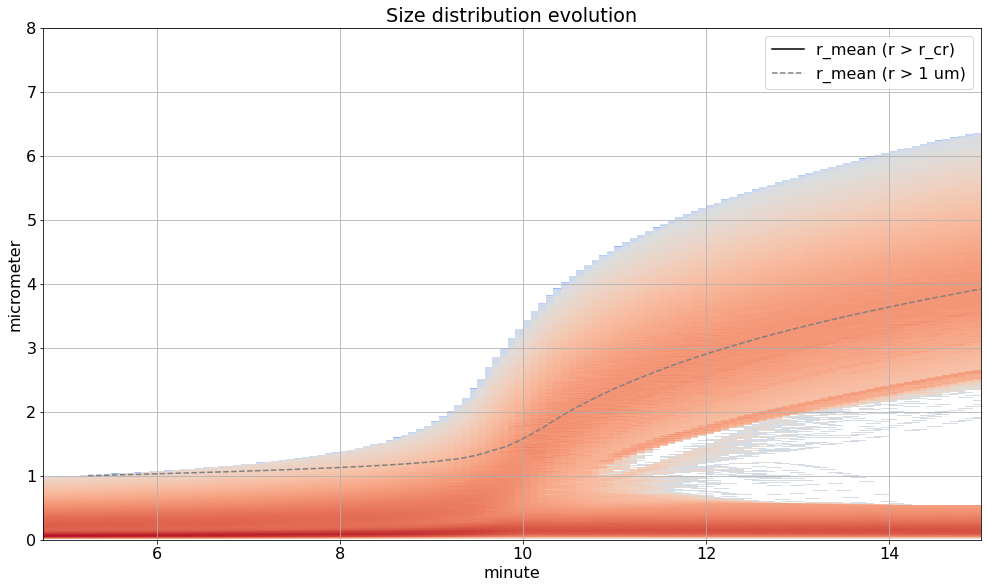

HTML(value="<a href='./spectrum.pdf' target='_blank'>./spectrum.pdf</a><br>")

In [26]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
ax = (ax,)

for i, output in enumerate(outputs):
    
    hist = output['r_bins_values']
    hist = (hist[:,0:-1] + hist[:,1:])/2
    xedges = output['t'].magnitude
    yedges = output['r_bins_edges']
    
    xunit = si.minute
    yunit = si.micrometres

    c = ax[i].pcolormesh(
        mgn(xedges * output['t'].units, xunit), 
        mgn(yedges * output['r'].units, yunit), 
        hist,
        cmap = 'coolwarm', shading='auto',
        norm = mpl.colors.LogNorm()
    )
    
    ax[i].set_title('Size distribution evolution')
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    
    ax[i].set_ylim([0, 8])

    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'].magnitude > output['r_cr']), label="r_mean (r > r_cr)", color='black')
    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'] > 1 * si.micrometre), label="r_mean (r > 1 um)", linestyle='--', color='gray')
    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='spectrum.pdf')

No handles with labels found to put in legend.


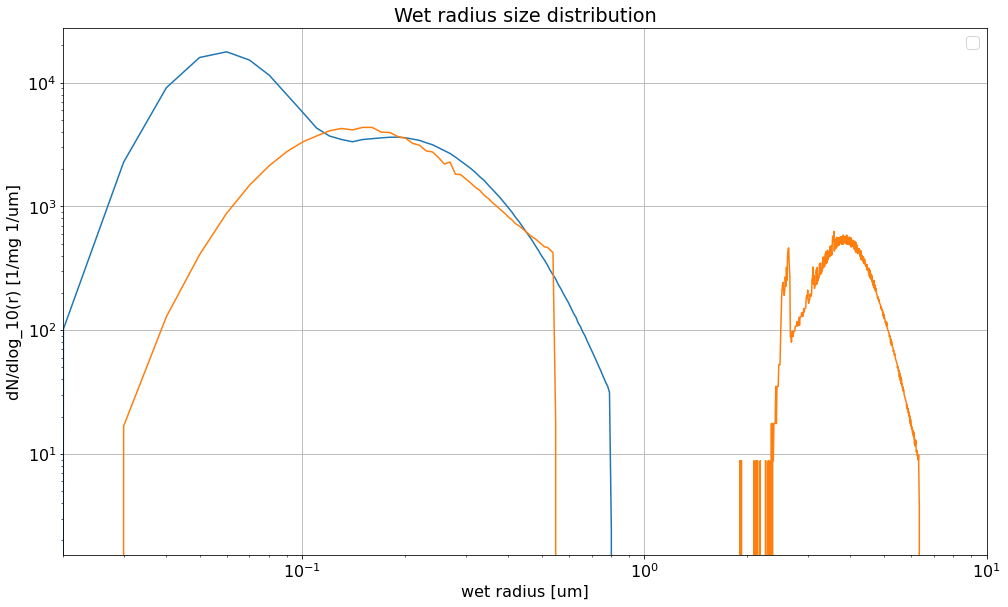

HTML(value="<a href='./Initial_and_final_size_distribution.pdf' target='_blank'>./Initial_and_final_size_distr…

In [33]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
ax = (ax,)

for i, output in enumerate(outputs):

    xunit = si.micrometres
    
    hist = output['r_bins_values']
    hist_init = (hist[:,0:-1] + hist[:,1:])/2
    edges = output['r_bins_edges']

    ax[i].plot(mgn(edges[1:] * output['r'].units, xunit), hist_init[:, -0])
    ax[i].plot(mgn(edges[1:] * output['r'].units, xunit), hist_init[:, -1])
    
    ax[i].set_title('Wet radius size distribution')
    ax[i].xaxis.set_units(xunit)
    ax[i].set_xlim([2e-2, 10])
    #ax[i].set_ylim([1, 2*1e4])

    plt.xscale("log")
    plt.yscale("log")  
    
    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    
    ax[i].set_xlabel("wet radius [um]")
    ax[i].set_ylabel("dN/dlog_10(r) [1/mg 1/um]")
    
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='Initial_and_final_size_distribution.pdf')

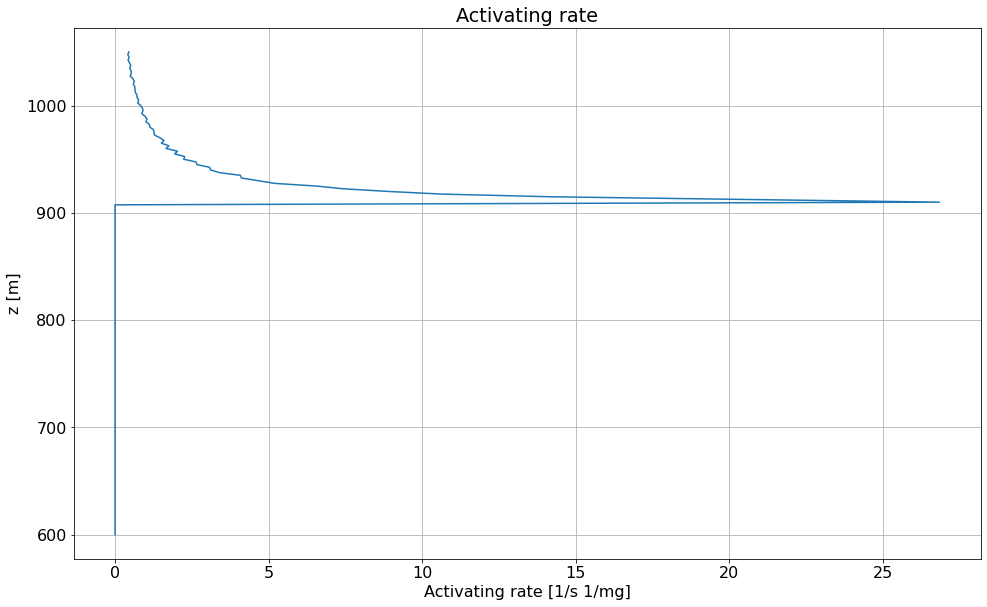

HTML(value="<a href='./Activating_rate.pdf' target='_blank'>./Activating_rate.pdf</a><br>")

In [30]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
ax = (ax,)

for i, output in enumerate(outputs):

    yunit = si.metres
    
    ax[i].set_title('Activating rate')
        
    ax[i].plot(output['activating_rate'], output['z'])
    ax[i].grid()
    plt.tight_layout()
    
    ax[i].set_xlabel("Activating rate [1/s 1/mg]")
    ax[i].set_ylabel("z [m]")
    
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='Activating_rate.pdf')

In [29]:
print("N_act = ", np.sum(output["activating_rate"]) * output["dt_output"])


N_act =  843.0216404958031
